<a href="https://colab.research.google.com/github/rubabshz/Rubab_INFO5731_Spring2020/blob/main/Rubab_In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
pip install pyLDAvis

In [30]:
import nltk
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import spacy

#Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [22]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [1]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)


In [31]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [32]:
#Reading from dataset
df = pd.read_csv("/content/GoogleScholarAAN.csv",sep='\t', encoding='latin1')

df=df.replace(u'\xa0', u'0')
df['Articles']=df['Articles'].str.replace('\xa0',' ')
df.head(10)

,Articles
0,Artificial neural networks
1,Artificial neural networks
2,Artificial neural networks: A tutorial
3,Artificial neural networks
4,Creating artificial neural networks that gener...
5,Evolving artificial neural networks
6,Artificial neural networks technology
7,Artificial neural networks for beginners
8,What are artificial neural networks?
9,Learning in artificial neural networks: A stat...


In [33]:
# Converitng Dataframe to list
data = df['Articles'].tolist()

In [34]:
#Tokenization and Punctuation
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

In [35]:
#Bi-gram and Tri-gram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [36]:
#Removing Stopwords and getting Bi-grams
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

In [37]:
#Lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [38]:
#Making Dictionary, Corpus and Term Document Frequency

id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [39]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('artificial', 1), ('network', 1), ('neural', 1)]]

In [40]:
#LDA Model with 20 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
#Computing Model Perplexity and Coherence Score
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.61435621658961

Coherence Score:  0.5103885949248278


In [44]:
#setting environment path & giving Mallet path
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this

--2021-03-20 03:51:53--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  15.3MB/s    in 1.0s    

2021-03-20 03:51:54 (15.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [45]:
#building LDA mallet Model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


In [47]:
#Compute coherence value for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
  return model_list, coherence_values

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization,start=2, limit=60, step=6)

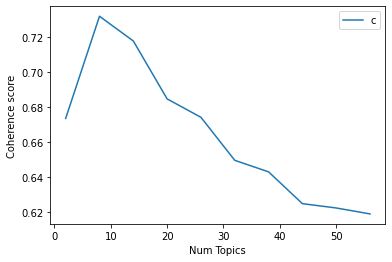

In [50]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.6736
Num Topics: 8  - Coherence Value: 0.732
Num Topics: 14  - Coherence Value: 0.7179
Num Topics: 20  - Coherence Value: 0.6848
Num Topics: 26  - Coherence Value: 0.6742
Num Topics: 32  - Coherence Value: 0.6496
Num Topics: 38  - Coherence Value: 0.643
Num Topics: 44  - Coherence Value: 0.6248
Num Topics: 50  - Coherence Value: 0.6224
Num Topics: 56  - Coherence Value: 0.619


In [52]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [53]:
#Printing Topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"neural" + 0.095*"network" + 0.094*"artificial" + 0.049*"enable" + '
  '0.049*"benefit" + 0.049*"medical" + 0.049*"nanophotonic" + '
  '0.049*"intervention" + 0.004*"introduction" + 0.003*"application"'),
 (1,
  '0.202*"artificial" + 0.200*"network" + 0.200*"neural" + 0.045*"application" '
  '+ 0.020*"perspective" + 0.015*"engineering" + 0.010*"base" + 0.010*"review" '
  '+ 0.010*"learn" + 0.010*"approximation"'),
 (2,
  '0.007*"artificial" + 0.007*"network" + 0.007*"neural" + 0.007*"application" '
  '+ 0.007*"medical" + 0.007*"use" + 0.007*"introduction" + 0.007*"practice" + '
  '0.007*"theory" + 0.007*"projection"'),
 (3,
  '0.153*"artificial" + 0.144*"neural" + 0.108*"network" + 0.069*"system" + '
  '0.052*"application" + 0.052*"energy" + 0.035*"evolve" + 0.018*"new" + '
  '0.018*"hydrology" + 0.018*"wave"'),
 (4,
  '0.132*"artificial" + 0.132*"neural" + 0.132*"network" + 0.045*"application" '
  '+ 0.045*"box" + 0.045*"black" + 0.023*"methodological" + '
  '0.023*"deve

In [55]:
#Topic Visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.182884  0.016716       1        1  34.515732
6     -0.112104  0.008091       2        1  16.530246
8     -0.092850 -0.128053       3        1  12.681356
7     -0.169065 -0.022178       4        1   8.988670
3     -0.113839  0.092534       5        1   8.648349
4     -0.086467  0.047744       6        1   6.670922
12     0.004118 -0.018666       7        1   2.876452
0     -0.000641 -0.019257       8        1   2.390647
10     0.036241  0.017183       9        1   2.290622
13     0.081102 -0.020036      10        1   1.788480
11     0.165062 -0.002338      11        1   0.797047
5      0.157109  0.009420      12        1   0.607159
9      0.157109  0.009420      13        1   0.607159
2      0.157109  0.009420      14        1   0.607159, topic_info=             Term       Freq      Total Category  logprob  loglift
1         network  81.000000  81.000000  Default  30.0000  30.0000
2          neural  83.000000  83.000000  Default  29.0000  29.0000
0      artificial  82.000000  82.000000  Default  28.0000  28.0000
12   introduction   6.000000   6.000000  Default  27.0000  27.0000
19    application  12.000000  12.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
21         design   0.020834   3.100659  Topic14  -5.0304   0.1013
22    fundamental   0.020834   2.267523  Topic14  -5.0304   0.4143
25          state   0.020834   2.267523  Topic14  -5.0304   0.4143
26  approximation   0.020834   2.407847  Topic14  -5.0304   0.3542
27   evolutionary   0.020834   3.911079  Topic14  -5.0304  -0.1309

[713 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
109       3  0.697526     account
139       4  0.721859    activity
129       1  0.664825    adaptive
52        6  0.733208     advance
123       3  0.697525   advantage
...     ...       ...         ...
141       4  0.721859   visualize
135       2  0.692664  wastewater
108       2  0.692665       water
87        5  0.723872        wave
73        1  0.664825    wireless

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 9, 8, 4, 5, 13, 1, 11, 14, 12, 6, 10, 3])

### Summarization of LDA Topics
1. Nanophotonic Introduction and Intervention of artificial neural network for the benefit of Medical application
2. Artificial Neural Network application from the perspective of an engineering learn and base review
3. Introduction to Artifical Neural Netwrok in the use and projection of medical theory
4. Artificial Neural Network application in new wave hydrology energy
5. Methodological advance black box development using artificial neural network application 
6. Introduction to use and make of artificial neural network application in medical practice
7. Evolutionary performance model for predicting wastewater performance using artificial neural network
8. Introduction to determining and visualizing optimum hidden structure activity using artificial neural network
9. Artificial Neural Network in regression prediction modelling in medical use
10. Artificial Neural Network application use in medical model perspective


## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [62]:
pip install lsa-program

     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 51kB 3.6MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for lsa-program: filename=lsa_program-0.3.0-cp37-none-any.whl size=12858 sha256=01cca38f46f95f61c0e4de49a0828b1a66efd20fa4854cbeb2e5289593b0c81f
  Stored in directory: /root/.cache/pip/wheels/0a/e3/38/bd4d5427de13816ef4a7019a166f115450455676b4da10b649
  Created wheel for bibtexparser: filename=bibtexparser-1.2.0-cp37-none-any.whl size=36712 sha256=c62699e57633027d22243ee7b42d069994a4ad49ade9ffe04fb9eb3d4cdb0d0f
  Stored in directory: /root/.cache/pip/wheels/b2/5a/e7/867bcbc3a81c15b675b931aa19b6698375c5a5e90419a366db
Successfully built lsa-program bibtexparser


In [63]:
#Import LSA Model
from gensim.models import LsiModel



In [69]:
#Building Model
lsamodel = LsiModel(corpus, 20, id2word)

In [65]:
#Computing coherence value for LSA
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

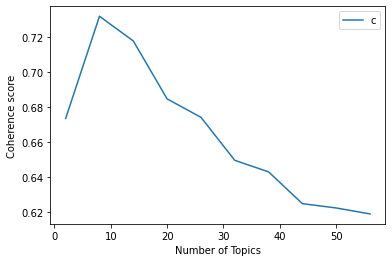

In [66]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [67]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.5251
Num Topics: 8  - Coherence Value: 0.5225
Num Topics: 14  - Coherence Value: 0.5251
Num Topics: 20  - Coherence Value: 0.5251
Num Topics: 26  - Coherence Value: 0.5068
Num Topics: 32  - Coherence Value: 0.5251
Num Topics: 38  - Coherence Value: 0.5251
Num Topics: 44  - Coherence Value: 0.5225
Num Topics: 50  - Coherence Value: 0.5225
Num Topics: 56  - Coherence Value: 0.5251


In [70]:
#Printing Topics
pprint(lsamodel.print_topics())

[(0,
  '0.576*"neural" + 0.572*"network" + 0.564*"artificial" + 0.077*"application" '
  '+ 0.048*"use" + 0.039*"introduction" + 0.030*"model" + 0.029*"medical" + '
  '0.024*"system" + 0.024*"prediction"'),
 (1,
  '0.796*"application" + -0.268*"use" + 0.238*"system" + 0.227*"energy" + '
  '-0.126*"model" + 0.116*"fundamental" + -0.106*"prediction" + 0.089*"review" '
  '+ -0.088*"network" + 0.086*"artificial"'),
 (2,
  '-0.661*"use" + -0.297*"application" + -0.240*"prediction" + '
  '-0.208*"performance" + 0.175*"introduction" + -0.174*"model" + '
  '-0.109*"classification" + -0.109*"cancer" + -0.109*"gene" + '
  '-0.109*"profile"'),
 (3,
  '-0.603*"medical" + -0.246*"logistic" + -0.246*"outcome" + '
  '-0.246*"advantage" + -0.246*"regression" + -0.246*"predict" + '
  '-0.246*"disadvantage" + 0.240*"model" + 0.210*"prediction" + '
  '-0.190*"diagnosis"'),
 (4,
  '-0.497*"model" + 0.330*"prediction" + 0.311*"introduction" + '
  '-0.197*"perspective" + -0.195*"information" + -0.186*"neural

### Summarization of LSA Topics
1. Artificial Neural Network use and application in medical system prediction
2. Fundamental application and use of artificial neural network in energy systems
3. Introduction to modeling and classification of cancer models gene profile 
4. Medical Logistic Diagnosis regression prediction outcome, advantages and disadvantages
5. Introduction to prediction modeling in ecological tools using artificial neural network
6. Introduction tutorial to artificial neural network and machine learning
7. Introduction to renewable energy evolutionary system
8. Information extraction, representation, and training technique 
9. Random Forest Model for change prediction using multivariate datum features
10. Fundamentals of geotechnical process in design engineering

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

Latent Dirichlet Allocation has a higher accuracy than the Latent Semantic Analysis. The highest coherence value for the LSA is 52, whereas, the highest LDA coherence value using LDA is 73. LSA topics seems to be concentrated too much on the jargons, whereas, LDA model has generalized the key words and topics.
The high coherence of LDA model make it easily generalizable and interpretable.